In [ ]:
import zipfile,cv2, os, matplotlib.pyplot as plt, numpy as np, torch, torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.utils.class_weight import compute_class_weight
from torchsummary import summary
from copy import deepcopy

In [1]:
# Extracting Data
with zipfile.ZipFile('images.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')


In [2]:
# Counting data
base_path = '/content/Data/images/train'

image_counts = {}

for emotion_folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, emotion_folder)
    if os.path.isdir(folder_path):
        count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        image_counts[emotion_folder] = count

for emotion, count in image_counts.items():
    print(f"{emotion}: {count} images")


neutral: 4982 images
angry: 3993 images
surprise: 3205 images
happy: 7164 images
disgust: 436 images
sad: 4938 images
fear: 4103 images


In [3]:
img_array=cv2.imread("/content/Data/images/train/angry/11315.jpg")

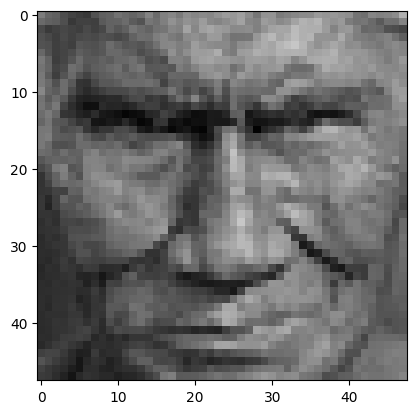

In [4]:
plt.imshow(img_array)

In [5]:
img_array.shape

(48, 48, 3)

In [6]:
# for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# for validation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='Data/images/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='Data/images/validation', transform=val_transforms)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# class EmotionMobileNetV2(nn.Module):
#     def __init__(self, num_classes=7):
#         super(EmotionMobileNetV2, self).__init__()

#         # Load pretrained MobileNetV2
#         self.base_model = models.mobilenet_v2(pretrained=True)

#         # Freeze all layers initially
#         for param in self.base_model.features.parameters():
#             param.requires_grad = False

#         # Remove original classifier
#         self.base_model.classifier = nn.Identity()

#         # Custom classification head with Dropout
#         self.custom_classifier = nn.Sequential(
#             nn.Linear(1280, 128),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, num_classes)
#         )

#     def forward(self, x):
#         x = self.base_model(x)
#         x = self.custom_classifier(x)
#         return x


In [7]:
class EmotionEfficientNetB0(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionEfficientNetB0, self).__init__()

        self.base_model = models.efficientnet_b0(pretrained=True)


        for param in self.base_model.features.parameters():
            param.requires_grad = False


        self.base_model.classifier = nn.Identity()

        self.custom_classifier = nn.Sequential(
            nn.Linear(1280, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.custom_classifier(x)
        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
targets = [label for _, label in train_dataset]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)


In [10]:
model=EmotionEfficientNetB0(num_classes=7).to(device)
# #criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', patience=3, factor=0.5, verbose=True
# )
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

best_acc = 0
early_stop_counter = 0
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 97.3MB/s]


In [11]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [15]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = total_correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

In [16]:
def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


In [17]:
def unfreeze_efficientnet(model):
    for param in model.base_model.features[5:].parameters():
        param.requires_grad = True


In [20]:
patience=3
patience_counter=0


for epoch in range(1, 51):
    if epoch == 10:
      unfreeze_efficientnet(model)
      print("✅ Unfroze last few layers of Efficientnet")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)
    scheduler.step(val_loss)



    print(f"Epoch {epoch} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if val_acc > best_acc:
      best_acc = val_acc
      patience_counter = 0
      torch.save(model.state_dict(), f"best.pt")
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break





histories = deepcopy(history)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 | Train Acc: 0.2220, Val Acc: 0.3500
Epoch 2 | Train Acc: 0.2806, Val Acc: 0.3660
Epoch 3 | Train Acc: 0.3090, Val Acc: 0.3490
Epoch 4 | Train Acc: 0.3177, Val Acc: 0.3767
Epoch 5 | Train Acc: 0.3276, Val Acc: 0.3924
Epoch 6 | Train Acc: 0.3331, Val Acc: 0.4065
Epoch 7 | Train Acc: 0.3427, Val Acc: 0.4098
Epoch 8 | Train Acc: 0.3469, Val Acc: 0.3943
Epoch 9 | Train Acc: 0.3556, Val Acc: 0.3882
✅ Unfroze last few layers of Efficientnet
Epoch 10 | Train Acc: 0.4647, Val Acc: 0.5609
Epoch 11 | Train Acc: 0.5376, Val Acc: 0.5941
Epoch 12 | Train Acc: 0.5677, Val Acc: 0.5686
Epoch 13 | Train Acc: 0.5812, Val Acc: 0.6001
Epoch 14 | Train Acc: 0.5953, Val Acc: 0.6162
Epoch 15 | Train Acc: 0.6005, Val Acc: 0.6111
Epoch 16 | Train Acc: 0.6153, Val Acc: 0.6139
Epoch 17 | Train Acc: 0.6173, Val Acc: 0.6391
Epoch 18 | Train Acc: 0.6254, Val Acc: 0.6204
Epoch 19 | Train Acc: 0.6334, Val Acc: 0.6335
Epoch 20 | Train Acc: 0.6383, Val Acc: 0.6282
Early stopping triggered


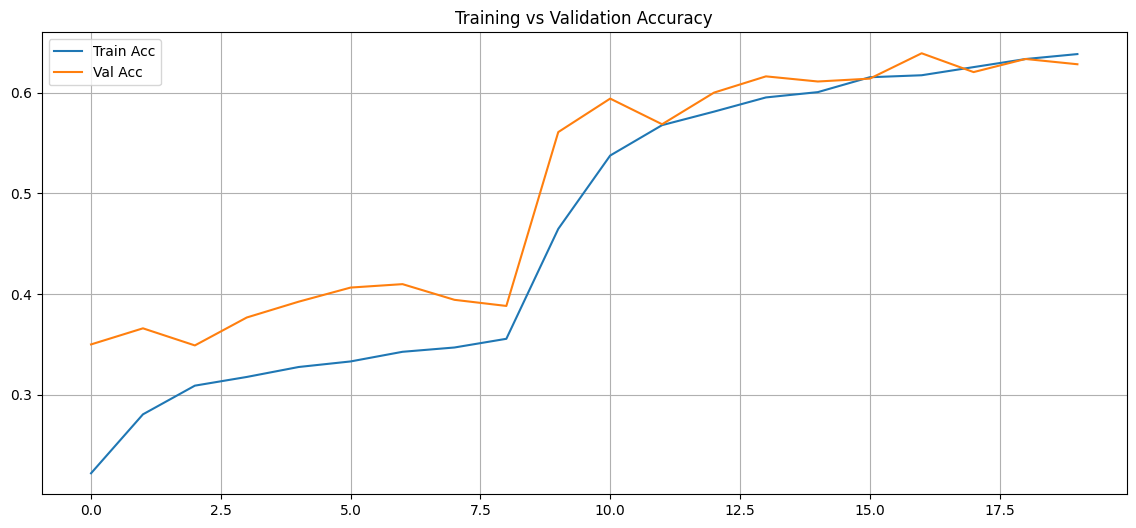

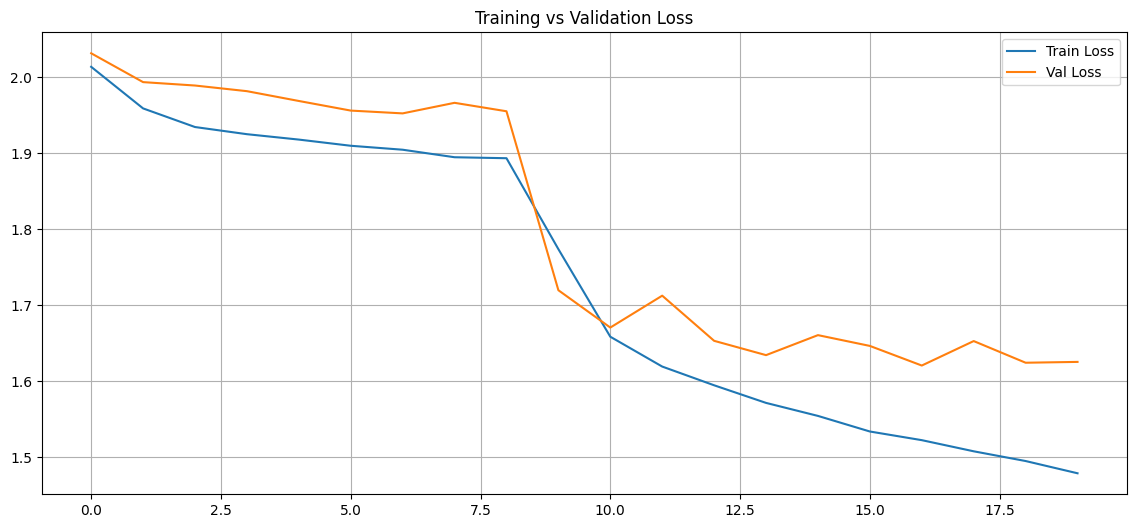

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(histories['train_acc'], label=f'Train Acc')
plt.plot(histories['val_acc'], label=f'Val Acc')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(histories['train_loss'], label=f'Train Loss')
plt.plot(histories['val_loss'], label=f'Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()
